# 2D Gaussian fits to images
Checking how bad the 2D Gaussian fits to the images actually are

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

# Suppressing warnings if desired (getting annoying warning about run names)
import warnings
warnings.filterwarnings(action = 'ignore')

from pathlib import Path
from typing import Union

import lmfit
import matplotlib.pyplot as plt
import numpy as np
from data_analysis import analyzers
from data_analysis import background_subtractors as BG_subtract
from data_analysis import (
    bootstrapping,
    cutters,
    plotters,
    preprocessors,
    retrievers,
    signal_calculators,
)


In [26]:


def make_some_gaussian_fits(
    filepath: Union[Path, str],
    run_name: Union[str, int],
    background_run_name: Union[str, int],
    scan_param_name: str,
    scan_param_new_name: str,
    switch_name: str = None,
    n_bs: int = 6,
):
    """
    Analyzes an SPA dataset
    """
    ##### Retrieving data from file #####
    # Initialize data retriever
    SPA_retriever = retrievers.SPARetriever()

    # Print datasets in data
    # SPA_retriever.print_run_names(filepath)

    if type(run_name) == int:
        run_name = SPA_retriever.get_run_names(filepath)[run_name]

    # Retrieve data
    df = SPA_retriever.retrieve_data(
        filepath,
        run_name,
        scan_param=scan_param_name,
        scan_param_new_name=scan_param_new_name,
    )

    ##### Processing data #####
    # Define preprocessors
    processors = [
        preprocessors.NormalizedAbsorption(),
        preprocessors.IntegratedAbsorption(),
        preprocessors.AbsorptionBigEnough(),
        preprocessors.YAGFired(),
        preprocessors.AbsorptionON(),
        preprocessors.RotCoolON(),
        preprocessors.RCShutterOpen(),
        preprocessors.CamDAQTimeDiff(),
        preprocessors.MicrowavesON(),
    ]

    # Define plotters that will be run after the preprocessing
    plotters_list = [plotters.PreProcessorPlotter()]

    # Define the data processing pipeline
    processor_pipeline = preprocessors.ProcessorPipeline(
        processors, plotters=plotters_list
    )

    # Pre-process the data
    processor_pipeline.process_data(df, plot=False)

    ##### Cutting data #####
    # Define cutters
    cutters_list = [
        cutters.YAGFiredCutter(),
        cutters.AbsorptionONCutter(),
        cutters.AbsBigEnoughCutter(),
        cutters.TimingCutter(),
    ]

    # Define cutter pipeline
    cutter_pipeline = cutters.CutterPipeline(cutters_list)

    # Apply cuts
    cutter_pipeline.apply_cuts(df, print_result=True)

    ##### Analyze preprocessed data #####
    # Define a background subtractor
    df_background = SPA_retriever.retrieve_data(filepath, background_run_name)
    background_subtractor = BG_subtract.AcquiredBackgroundSubtractor(df_background)

    # Define a signal size calculator
    init_params = lmfit.Parameters()
    init_params.add("A", value=10, min=0)
    init_params.add("center_x", value=200, min=0, max=512)  # , vary = False)
    init_params.add("center_y", value=250, min=0, max=512)  # , vary = False)
    init_params.add("phi", value=0, min=0, max=np.pi / 4)
    init_params.add("sigma_x", value=16, min=10, max=100)
    init_params.add("sigma_y", value=30, min=10, max=100)
    init_params.add("C", value=0)
    signal_size_calculator = signal_calculators.SignalFromGaussianFit(   plotter = plotters.GaussianFitPlotter(),
        init_params=init_params, ROI=np.s_[150:450, 100:300]
    )

    # Define an analyzer
    analyzers_list = [
        analyzers.FluorescenceImageAnalyzer(
            background_subtractor, signal_size_calculator
        )
    ]

    # Define a parameter scan analyzer
    if switch_name:
        scan_analyzer = analyzers.SwitchingParamScanAnalyzer(
            scan_param_new_name,
            switch_name,
            analyzers_list,
            # plotter = SwitchingParamScanPlotter()
        )
    else:
        print('yo')
        scan_analyzer = analyzers.ParamScanAnalyzer(
            scan_param_new_name,
            analyzers_list,
            # plotter = ParamScanPlotter()
        )
    
    df = scan_analyzer.analyze_data(df)
    
    return df

Set up paths:

In [27]:
# Define path to data
DATA_DIR = Path(
    "G:\My Drive\CeNTREX Oskari\State preparation\SPA\Data analysis\Data"
)
DATA_FNAME = Path("SPA_test_12_2_2021.hdf")
filepath = DATA_DIR / DATA_FNAME

## Depletion on R(0), F' = 2

Percentage of data cut: 1.72 %
<class 'data_analysis.analyzers.SwitchingParamScanAnalyzer'>


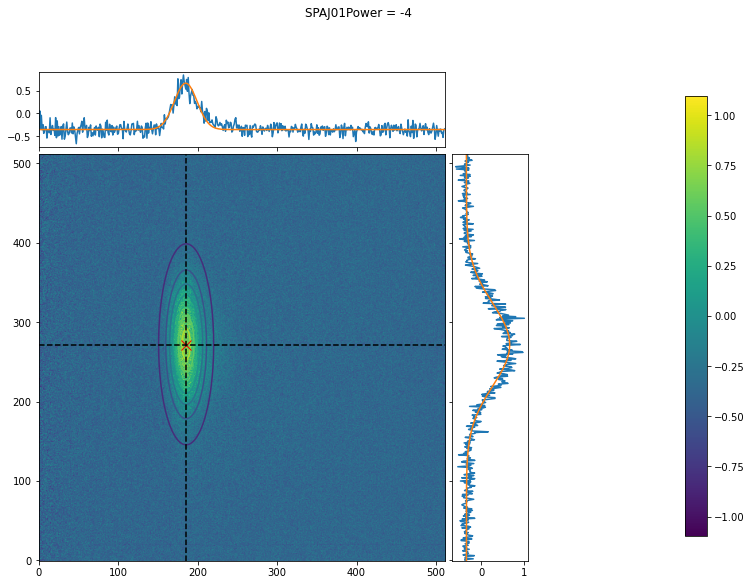

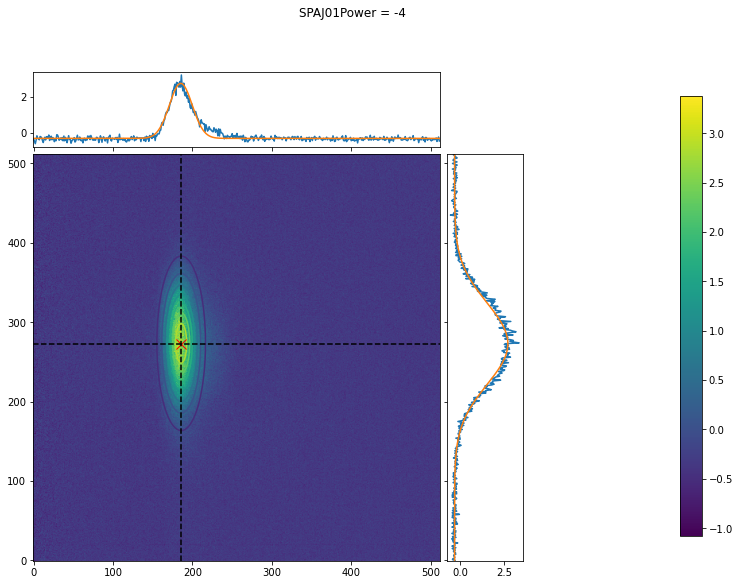

In [28]:
df_R0F2 = make_some_gaussian_fits(
    filepath,
    10,
    0,
    scan_param_name='SynthHD Pro SPA SetPowerCHAGUI',
    scan_param_new_name='SPAJ01Power',
    switch_name = 'MicrowavesON',
)

## Accumulation on R(1), F' = 3

Percentage of data cut: 2.50 %
<class 'data_analysis.analyzers.SwitchingParamScanAnalyzer'>


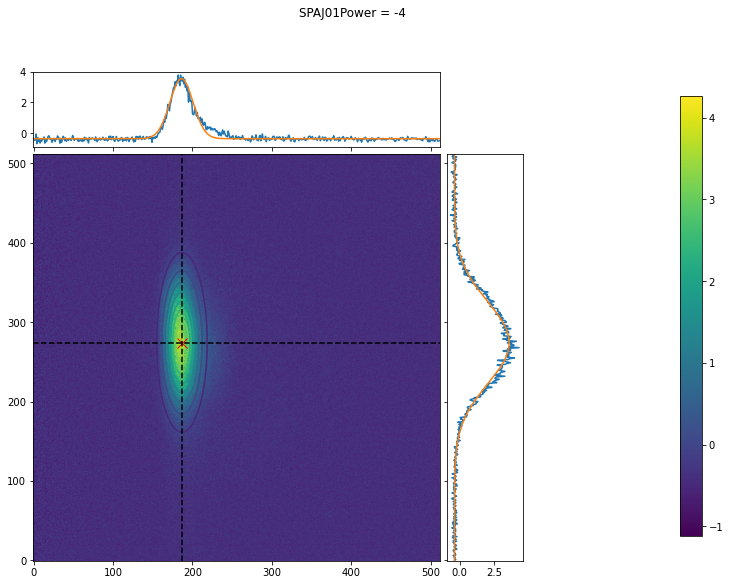

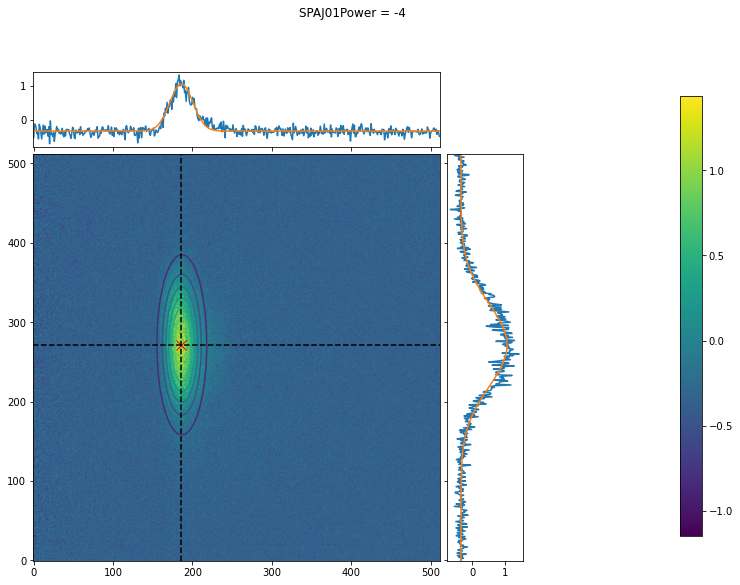

In [31]:
df_R1F3_depl = make_some_gaussian_fits(
    filepath,
    12,
    0,
    scan_param_name='SynthHD Pro SPA SetPowerCHAGUI',
    scan_param_new_name='SPAJ01Power',
    switch_name = 'MicrowavesON',
)

## Depletion on R(1), F' = 3

Percentage of data cut: 1.83 %
<class 'data_analysis.analyzers.SwitchingParamScanAnalyzer'>


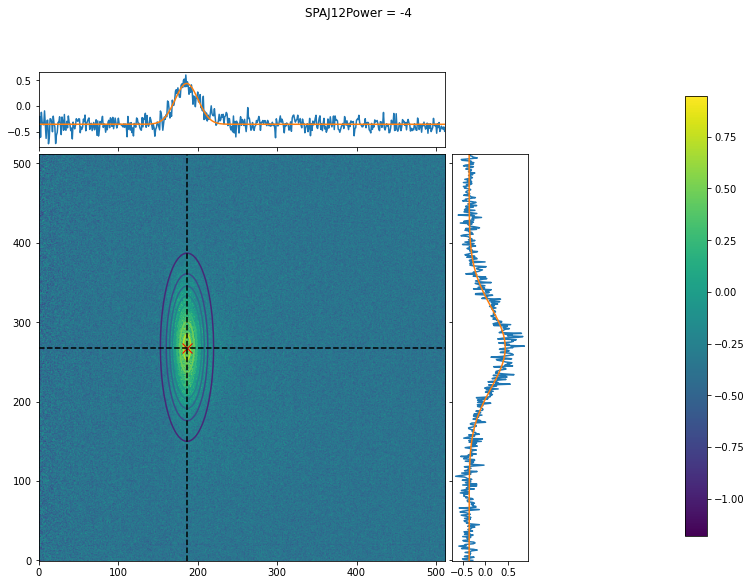

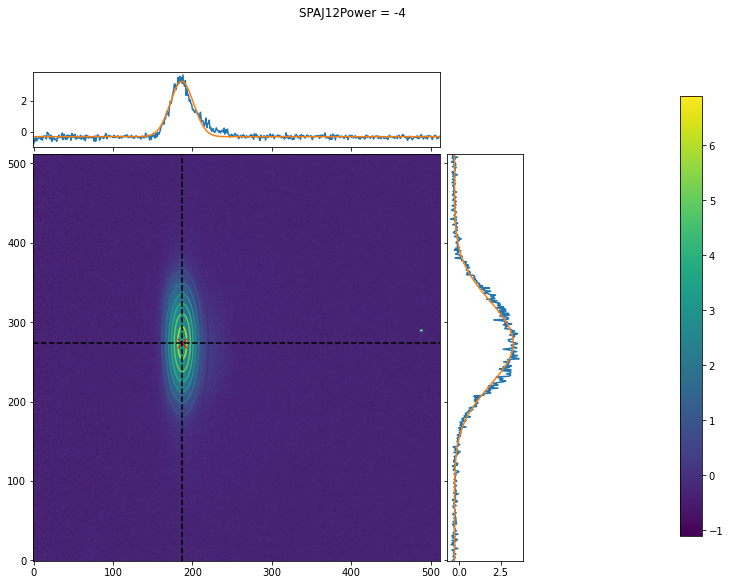

In [35]:
df_R1F3_depl = make_some_gaussian_fits(
    filepath,
    15,
    0,
    scan_param_name='SynthHD Pro SPA J12 SetPowerCHAGUI',
    scan_param_new_name='SPAJ12Power',
    switch_name = 'MicrowavesON',
)

## Depletion on R(2), F' = 4

Percentage of data cut: 4.33 %
<class 'data_analysis.analyzers.SwitchingParamScanAnalyzer'>


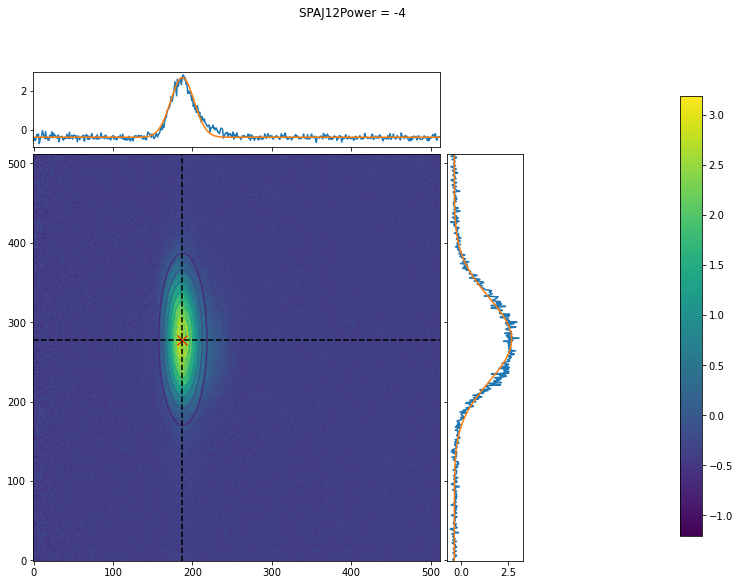

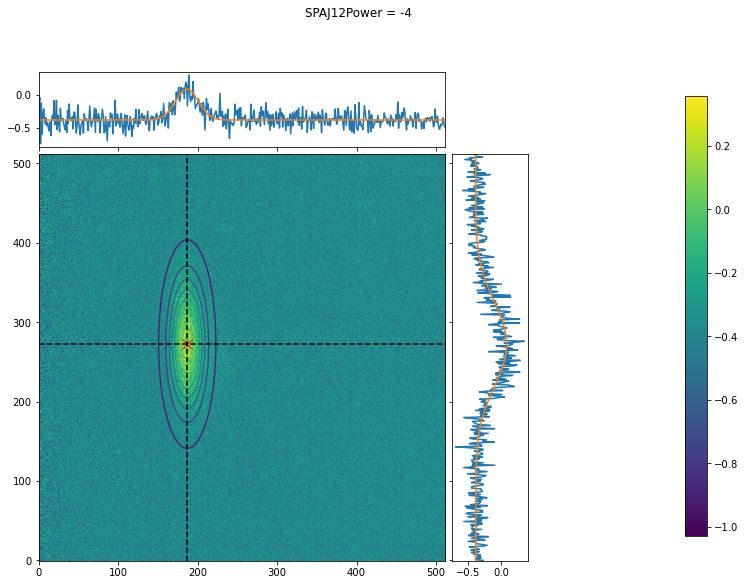

In [36]:
df_R2F4 = make_some_gaussian_fits(
    filepath,
    17,
    0,
    scan_param_name='SynthHD Pro SPA J12 SetPowerCHAGUI',
    scan_param_new_name='SPAJ12Power',
    switch_name = 'MicrowavesON',
)